**downloading the dataset**

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# # !pip install kaggle
# !mkdir ~/.kaggle
# # download kaggle.json (from kaggle->account->settings->api->new_Token) and upload in colab first
# !cp /content/kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json
# # # https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
# !kaggle datasets download -d ananthu017/emotion-detection-fer
# # relpace the name with downladed zip file name
# !unzip emotion-detection-fer.zip

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "title"
        style = "padding: 18px; 
                 color: #f8f7e4;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">&#8759;
        <a class="anchor-link" 
            id="title" href="https://www.kaggle.com/charlesanjah/optimizing-facial-emotion-detection-efficientnet/notebook#title"
            style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 text-decoration: none;
                 font-weight: bold;
                 align: centre;"          
            >
        Optimising Facial Emotion Detection with Deep Learning </a>
    </h1>
</div>

<img src="https://acart.com/wp-content/uploads/2017/04/faceplus-example.png" alt="Facial Recognition And Emotion Detection Model" style="width:100%;height:400px;">


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "import-libraries"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">&#8759; Import Standard Libraries
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#import-libraries">¶</a>
    </h1>
</div>

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as npy # linear algebra
import pandas as pds # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [7]:
# Read all files from folders
import os, sys, time, warnings, sklearn
ROOT='/content'
# ROOT='data'
# for dirname, _, filenames in os.walk(ROOT):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [8]:
# Specify important directories
TRAIN_PATH=ROOT+'/train'
TEST_PATH=ROOT+'/test'
train_angry_img_path = ROOT+'/train/angry'

OVERSAMPLED_TRAIN_PATH= ROOT+'/fed_oversampled_train'
MODEL_PATH=ROOT+'/models'
IMAGE_PATH=ROOT+'/images'

# Model Architecture path
def model_arch(model_name):
    !mkdir images
    arch=IMAGE_PATH+'/fer-2013_'+model_name+'.png'
    return arch

#  TensorFlow Checkpoint save_weight uses .ckpt extension format
def checkpoint_path(model_name):
    checkpoint_path = MODEL_PATH+"/fedav_best_model-"+model_name+".ckpt"
    return checkpoint_path
    


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "exploratory-da"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Exploratory Data Analysis
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#exploratory-da">¶</a>
    </h1>
</div>

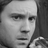

In [9]:
# Load a sample image 
# using open() to open images
image_data = Image.open(train_angry_img_path+'/im0.png')
image_data

Image shape: (48, 48)
Image data array: [[ 70  80  82 ...  52  43  41]
 [ 65  61  58 ...  56  52  44]
 [ 50  43  54 ...  49  56  47]
 ...
 [ 91  65  42 ...  72  56  43]
 [ 77  82  79 ... 105  70  46]
 [ 77  72  84 ... 106 109  82]]
Image array shape: (48, 48)


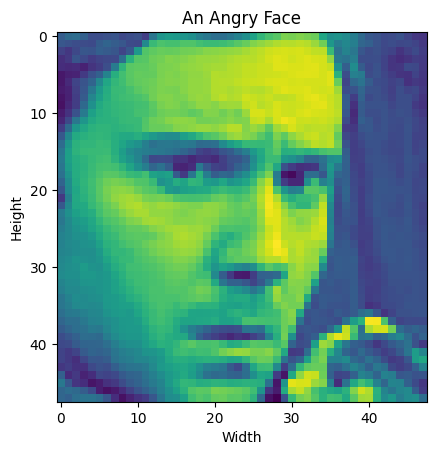

In [10]:
# Get the shape of the image
image=plt.imread(train_angry_img_path+'/im0.png')
print(f'Image shape: {image.shape}')

# Convert image data (like jpeg) to numpy using asarray()
image_array = npy.asarray(image_data)
print(f'Image data array: {image_array}')

# Get the shape of the image array
print(f'Image array shape: {image_array.shape}')

# Printing the image 
plt.imshow(image_array)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('An Angry Face')
plt.show()

In [11]:
# Get the list of folders in the directory as classes
class_dir=os.listdir(TRAIN_PATH+'/')
class_dir

['surprised', 'sad', 'happy', 'disgusted', 'fearful', 'neutral', 'angry']

 For Statistical Analysis, we'll load the images, convert them to numpy arrays, and store them in a pandas dataframe with the columns 'filename', 'image', and 'label'

In [12]:
# set up file paths and labels
folder_names = class_dir
label_dict = {folder_names[i]:i for i in range(len(folder_names))}
image_filenames = []
labels = []

# iterate through each folder and collect filenames and labels
for folder_name in folder_names:
    folder_path = os.path.join(TRAIN_PATH, folder_name)
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            image_filenames.append(os.path.join(folder_name, filename))
            labels.append(label_dict[folder_name])

# create pandas dataframe
df = pds.DataFrame({'filename': image_filenames, 'emotion': labels})

# add 'image' column to dataframe
image_array_list = []
for filename in df['filename']:
    img_path = os.path.join(TRAIN_PATH, filename)
    img = Image.open(img_path)
    img_array = npy.array(img).flatten()
    image_array_list.append(img_array)
df['image'] = image_array_list

dfcopy = df.copy()

# strip and replace commas in 'image' column
# df['image'] = df['image'].apply(lambda x: x.strip('[]').replace(',', ' '))

# convert the image column to a string with comma-separated values
df['image'] = df['image'].apply(lambda x: ' '.join(map(str, x.tolist())))

# remove square brackets from the string representation of the array
df['image'] = df['image'].str.replace('[', '').str.replace(']', '')


# Export the preprocessed file to CSV
!mkdir output
df.to_csv('output/fer-2013-images_preprocessed.csv', index=False)

# display dataframe
cm = sns.light_palette("green", as_cmap=True)
df.tail(10).style.background_gradient(cmap=cm, text_color_threshold = 0.1).format(precision=2).highlight_null('red').set_properties(**{'background-color': '#256d7c;', 'color': 'white'}, subset=['filename'])
df

<ipython-input-12-a626fd90e2d0>:36: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['image'] = df['image'].str.replace('[', '').str.replace(']', '')


filename  emotion  \
0      surprised/im2501.png        0   
1      surprised/im2774.png        0   
2      surprised/im2762.png        0   
3       surprised/im910.png        0   
4      surprised/im1434.png        0   
...                     ...      ...   
28704       angry/im306.png        6   
28705      angry/im2237.png        6   
28706      angry/im3367.png        6   
28707      angry/im2072.png        6   
28708       angry/im465.png        6   

                                                   image  
0      166 166 166 163 162 158 153 147 139 136 138 13...  
1      1 1 19 33 47 50 68 57 33 65 95 57 54 70 65 70 ...  
2      136 138 139 141 148 130 124 125 114 106 90 82 ...  
3      5 9 52 89 70 27 19 31 53 74 106 143 160 154 14...  
4      28 3 1 0 1 0 40 94 111 102 89 100 136 133 145 ...  
...                                                  ...  
28704  72 62 85 97 86 87 81 101 121 137 155 166 177 1...  
28705  214 220 182 121 122 76 37 44 46 42 66 73 65 75...  
28706  17 23 19 36 30 55 69 60 43 38 63 59 58 70 57 8...  
28707  36 33 30 31 34 51 78 84 93 102 105 94 92 92 92...  
28708  44 17 8 29 30 7 1 1 8 7 6 3 24 63 108 123 122 ...  

[28709 rows x 3 columns]

In [13]:
df.emotion.value_counts().unique()

array([7215, 4965, 4830, 4097, 3995, 3171,  436])

In [14]:
dfcopy

filename  emotion  \
0      surprised/im2501.png        0   
1      surprised/im2774.png        0   
2      surprised/im2762.png        0   
3       surprised/im910.png        0   
4      surprised/im1434.png        0   
...                     ...      ...   
28704       angry/im306.png        6   
28705      angry/im2237.png        6   
28706      angry/im3367.png        6   
28707      angry/im2072.png        6   
28708       angry/im465.png        6   

                                                   image  
0      [166, 166, 166, 163, 162, 158, 153, 147, 139, ...  
1      [1, 1, 19, 33, 47, 50, 68, 57, 33, 65, 95, 57,...  
2      [136, 138, 139, 141, 148, 130, 124, 125, 114, ...  
3      [5, 9, 52, 89, 70, 27, 19, 31, 53, 74, 106, 14...  
4      [28, 3, 1, 0, 1, 0, 40, 94, 111, 102, 89, 100,...  
...                                                  ...  
28704  [72, 62, 85, 97, 86, 87, 81, 101, 121, 137, 15...  
28705  [214, 220, 182, 121, 122, 76, 37, 44, 46, 42, ...  
28706  [17, 23, 19, 36, 30, 55, 69, 60, 43, 38, 63, 5...  
28707  [36, 33, 30, 31, 34, 51, 78, 84, 93, 102, 105,...  
28708  [44, 17, 8, 29, 30, 7, 1, 1, 8, 7, 6, 3, 24, 6...  

[28709 rows x 3 columns]

In [15]:
# dfcopy = df.copy()
dfcopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28709 non-null  object
 1   emotion   28709 non-null  int64 
 2   image     28709 non-null  object
dtypes: int64(1), object(2)
memory usage: 673.0+ KB


In [16]:
# Computing the mean and standard deviation of the pixel values in each image
mean_values = [npy.mean(img) for img in dfcopy['image']]
std_values = [npy.std(img) for img in dfcopy['image']]

# add new columns for mean and standard deviation
dfcopy['pixel_mean'] = mean_values
dfcopy['pixel_std'] = std_values

dfcopy= dfcopy[['filename', 'image', 'pixel_mean', 'pixel_std', 'emotion']]
# print statistical summary
dfcopy.tail(10).style.background_gradient(cmap=cm, text_color_threshold = 0.1).format(precision=2).highlight_null('red').set_properties(**{'background-color': '#256d7c;', 'color': 'white'}, subset=['filename', 'image'])

In [17]:
dfcopy.describe().style.background_gradient(cmap=cm, text_color_threshold = 0.1).format(precision=2).highlight_null('red').set_properties(**{'background-color': '#256d7c;', 'color': 'white'}, subset=['emotion'])


In [18]:
# Get dictionary list of image count per class
def class_sample(type):
    if type.lower() == 'test' or type.lower() == 'train':
        path=''
        if type.lower() == 'train':    
            path= TRAIN_PATH
        else:
            path= TEST_PATH
        
        filepath=path+'/'
        class_count = []
        class_dict ={}
        for folder in os.listdir(filepath) :
              class_count.append(len(os.listdir(filepath+folder)))
              class_dict[folder]=len(os.listdir(filepath+folder))
        class_total = sum(class_count)
        return class_total, class_count, class_dict
    else:
        raise ValueError('Invalid type. Must be "test" or "train".')


def test_train_distribution():
      print("---- Train Set ----")
      avg_train=class_sample('train')[0]/len(class_sample('train')[1])
      print(f'Train class distribution:\n{class_sample("train")[2]}')
      print("Average train class: ",round(avg_train))    
      print('Total train: ', class_sample('train')[0])

      print("\n---- Test Set ----")
      avg_test=class_sample('test')[0]/len(class_sample('test')[1])
      print(f'Test class distribution:\n{class_sample("test")[2]}')
      print("Average test class: ",round(avg_test)) 
      print('Total test: ', class_sample('test')[0])


test_train_distribution()

# test_samples=class_sample('test')[0]
# test_batch_size=sorted([int(test_samples/n) for n in range(1,test_samples+1) if test_samples % n ==0 and test_samples/n<=80],reverse=True)[0]  


---- Train Set ----
Train class distribution:
{'surprised': 3171, 'sad': 4830, 'happy': 7215, 'disgusted': 436, 'fearful': 4097, 'neutral': 4965, 'angry': 3995}
Average train class:  4101
Total train:  28709

---- Test Set ----
Test class distribution:
{'surprised': 831, 'sad': 1247, 'happy': 1774, 'disgusted': 111, 'fearful': 1024, 'neutral': 1233, 'angry': 958}
Average test class:  1025
Total test:  7178


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "data-visualization"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Data Visualization
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#data-visualization">¶</a>
    </h1>
</div>

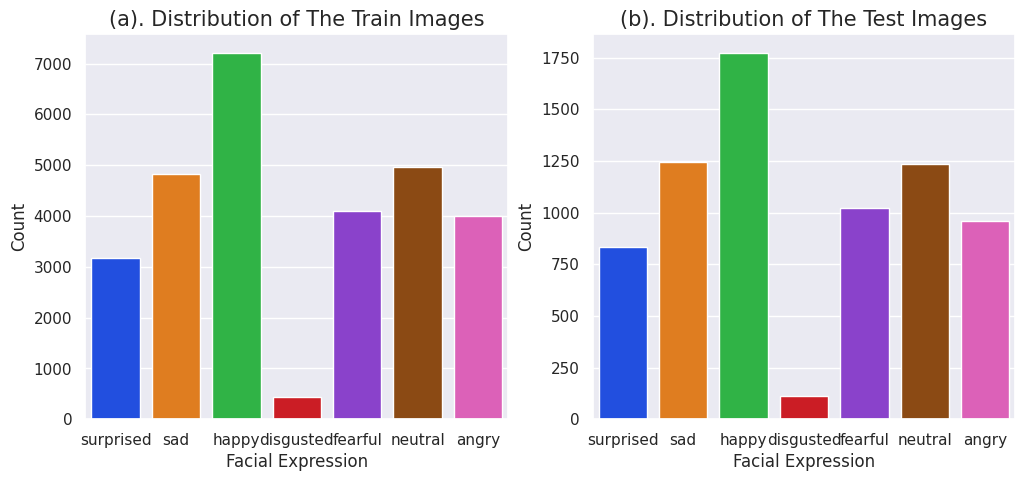

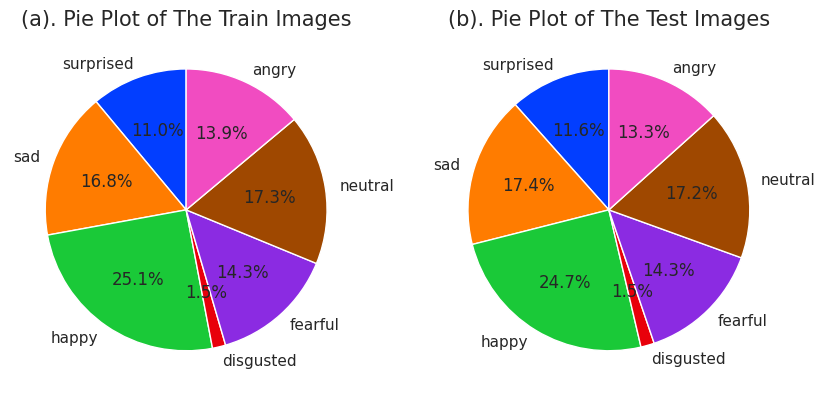

In [19]:
df_train = pds.DataFrame(list(class_sample("train")[2].items()), columns=['Emotion', 'Count'])
df_train.index.name = 'Emotion'
df_test = pds.DataFrame(list(class_sample("test")[2].items()), columns=['Emotion', 'Count'])
df_test.index.name = 'Emotion'


# plot a barplot with vertical orientation
sns.set()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
axis = sns.barplot(x='Emotion', y='Count', data=df_train, orient='v', palette='bright')
# set labels and title
plt.xlabel("Facial Expression", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("(a). Distribution of The Train Images", fontsize=15)
# plt.legend( df_train.Emotion, loc='upper left')
# set x-axis tick labels
# axis.set_xticks(range(len(df_train.Emotion)), df_train.Emotion)
# axis.yaxis.set_major_locator(ticker.MultipleLocator(2.5))

plt.subplot(1, 2, 2)
sns.barplot(x='Emotion', y='Count', data=df_test, orient='v', palette='bright')
plt.xlabel("Facial Expression", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("(b). Distribution of The Test Images", fontsize=15)
plt.show()

print('\n\n')

x_train = npy.array([ len(os.listdir(TRAIN_PATH+'/'+class_name+'/')) for class_name in class_dir])
x_test = npy.array([ len(os.listdir(TEST_PATH+'/'+class_name+'/')) for class_name in class_dir])
label = class_dir
  
# plot a Pie plot with vertical orientation
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')
plt.pie(x_train, labels=label, colors=palette_color, autopct='%1.1f%%', startangle=90)
ax.set_title('(a). Pie Plot of The Train Images', fontsize=15)

ay = plt.subplot(1, 2, 2)
plt.pie(x_test, labels=label, colors=palette_color, autopct='%1.1f%%', startangle=90)
ay.set_title('(b). Pie Plot of The Test Images', fontsize=15)
plt.show()



<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "data-preprocessing"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Data Preprocessing
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#data-preprocessing">¶</a>
    </h1>
</div>

<div>
    <h2 style = "padding: 3px; 
                 color: #256d7c;
                 font-size: 30px;
                 font-family: Cambria;
                 font-weight: bold;">Oversampling
    </h2>
</div>

In [20]:
# Oversampling Technique
import os
from PIL import Image

# Define the paths to the original and oversampled dataset
train_dir = TRAIN_PATH
oversampled_dir = OVERSAMPLED_TRAIN_PATH

target_length = 7215 # Using the highest count 
# target_length = 4101 # Using the average 

if not os.path.exists(oversampled_dir):
    os.mkdir(oversampled_dir)

for subfolder in os.listdir(train_dir):
    subfolder_path = os.path.join(train_dir, subfolder)
    if os.path.isdir(subfolder_path):
        num_images = len(os.listdir(subfolder_path))
        num_duplicates = target_length // num_images
        remainder = target_length % num_images

        for i in range(num_duplicates):
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)
                image = Image.open(image_path)
                new_image_file = f"{i}_{image_file}"
                new_image_path = os.path.join(oversampled_dir, subfolder, new_image_file)
                if not os.path.exists(os.path.join(oversampled_dir, subfolder)):
                    os.mkdir(os.path.join(oversampled_dir, subfolder))
                image.save(new_image_path)

        if remainder != 0:
            for image_file in os.listdir(subfolder_path)[:remainder]:
                image_path = os.path.join(subfolder_path, image_file)
                image = Image.open(image_path)
                new_image_file = f"{num_duplicates}_{image_file}"
                new_image_path = os.path.join(oversampled_dir, subfolder, new_image_file)
                if not os.path.exists(os.path.join(oversampled_dir, subfolder)):
                    os.mkdir(os.path.join(oversampled_dir, subfolder))
                image.save(new_image_path)


In [21]:
# Get dictionary list of image count per class
def over_class_sample():
        filepath=OVERSAMPLED_TRAIN_PATH+'/'
        class_count = []
        class_dict ={}
        for folder in os.listdir(filepath) :
              class_count.append(len(os.listdir(filepath+folder)))
              class_dict[folder]=len(os.listdir(filepath+folder))
        class_total = sum(class_count)
        return class_total, class_count, class_dict
 

# test_samples=class_sample('test')[0]
# test_batch_size=sorted([int(test_samples/n) for n in range(1,test_samples+1) if test_samples % n ==0 and test_samples/n<=80],reverse=True)[0]  


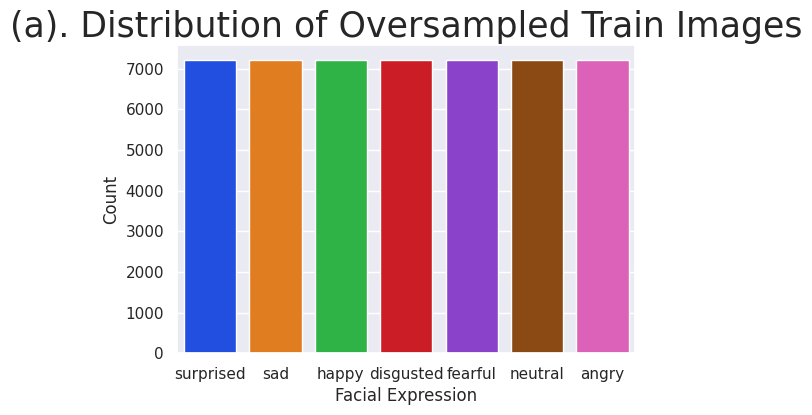


---- Oversampled Train Set ----
Train class distribution:
{'surprised': 7215, 'sad': 7215, 'happy': 7215, 'disgusted': 7215, 'fearful': 7215, 'neutral': 7215, 'angry': 7215}
Average train class:  7215
Total train:  50505


In [22]:
df_overtrain = pds.DataFrame(list(over_class_sample()[2].items()), columns=['Emotion', 'Count'])
df_overtrain.index.name = 'Emotion'


# plot a barplot with vertical orientation
sns.set()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
axis = sns.barplot(x='Emotion', y='Count', data=df_overtrain, orient='v', palette='bright')
# set labels and title
plt.xlabel("Facial Expression", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("(a). Distribution of Oversampled Train Images", fontsize=25)
plt.show()



def test_train_distribution():
      print("\n---- Oversampled Train Set ----")
      avg_train=over_class_sample()[0]/len(over_class_sample()[1])
      print(f'Train class distribution:\n{over_class_sample()[2]}')
      print("Average train class: ",round(avg_train))    
      print('Total train: ', over_class_sample()[0])



test_train_distribution()


<div>
    <h2 style = "padding: 3px; 
                 color: #256d7c;
                 font-size: 30px;
                 font-family: Cambria;
                 font-weight: bold;">Data Augmentation
    </h2>
</div>

In [23]:
#Definnig a function to do so 
def grayscale_RGB_and_upsizing(image,size=[224,224]):
    # image = tf.image.grayscale_to_rgb(tf.convert_to_tensor(image))
    image = tf.image.resize(tf.convert_to_tensor(image), size)
    return image

In [24]:
target_size=(48, 48)
# target_size=(224, 224)
batch_size=32

## Train Image Data Generator instance. 
# We will not apply any transformon specific orientations or features and no initial rescale to the image
# We'll only split the image data into train and validation set
trainValidation_data_generator = ImgDataGen(
                                            # rescale=1./225,
                                            rotation_range=10,  # Randomly rotate images by up to 10 degrees
                                            zoom_range=0.2,  # Randomly zoom images by up to 20%
                                            width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the image width
                                            height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of the image height
                                            shear_range=0.2,  # Randomly apply shearing transformations
                                            horizontal_flip=True,  # Randomly flip images horizontally
                                            fill_mode='nearest',  # Fill in missing pixels with the nearest value
                                            # preprocessing_function=grayscale_RGB_and_upsizing,
                                            validation_split=0.2    # set the validation split                                
                                            )

# Test Image Data Generator instance for Test data
validation_data_generator = ImgDataGen(
                                    validation_split=0.14,
                                    )

# Test Image Data Generator instance for Test data
test_data_generator = ImgDataGen(
                                # rescale = 1./255,
                                )

# Set a random seed to synchronize the shuffle order across different runs of the generator
# trainValidation_data_generator.set_seed(42)


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "create-train-validation-and-test-generators"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Create Train, Validation, and Test Generators
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#create-train-validation-and-test-generators">¶</a>
    </h1>
</div>

In [25]:
# Successfully mapped the train-images to their classes from the dataframe. Now let's do the same for the test-images. 
# Here, I will only be rescaling. No other transformations are applies, to preserve originality of the images.


## Mapping images to their classes.
print('Train Set Generated - ',end=' ') 
train_generator = trainValidation_data_generator.flow_from_directory(
                                                            directory=OVERSAMPLED_TRAIN_PATH, 
                                                            # directory=TRAIN_PATH, 
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical', 
                                                            color_mode='rgb', 
#                                                             classes=classes,
                                                            shuffle=True, 
                                                            subset='training' # set as training data
                                                        )
## Mapping images to their classes.
print('Validation Set Generated - ',end=' ') 
validation_generator = trainValidation_data_generator.flow_from_directory(
                                                            # directory=TRAIN_PATH, 
                                                            directory=OVERSAMPLED_TRAIN_PATH, 
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical', 
                                                            color_mode='rgb', 
#                                                             classes= classes,
                                                            shuffle=False, 
                                                            subset='validation' # set as validation data
                                                        )
test_samples=class_sample('test')[0]
test_batch_size=batch_size
test_steps=int(test_samples/test_batch_size)

## Mapping images to their classes.
print('Test Set Generated - ',end=' ') 
test_generator = test_data_generator.flow_from_directory(
                                        directory=TEST_PATH, 
                                        target_size=target_size,
                                        class_mode='categorical', 
                                        color_mode='rgb', 
#                                         classes=classes,
                                        shuffle=False, 
                                        batch_size=test_batch_size
                                        )

## Mapping shuffled images to their classes.
print('Shuffled Test Set Generated - ',end=' ') 
test_generator_shuffled = test_data_generator.flow_from_directory(
                                        TEST_PATH, 
                                        target_size=target_size,
                                        class_mode='categorical', 
                                        color_mode='rgb', 
#                                         classes=classes,
                                        shuffle=True, 
                                        batch_size=test_batch_size
                                        )

Train Set Generated -  Found 40404 images belonging to 7 classes.
Validation Set Generated -  Found 10101 images belonging to 7 classes.
Test Set Generated -  Found 7178 images belonging to 7 classes.
Shuffled Test Set Generated -  Found 7178 images belonging to 7 classes.


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "more-on-data-analysis"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">More on Data Analysis
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#more-on-data-analysis">¶</a>
    </h1>
</div>

In [26]:
# From the generator we can get information we will need later
# classes=  # os.listdir(TRAIN_PATH+'/')
class_dictionary = train_generator.class_indices
class_keys = list(train_generator.class_indices.keys())
class_values = list(train_generator.class_indices.values())
class_count = len(class_keys)

print ('test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

train_images, train_labels = next(train_generator)
validation_images, validation_labels = next(validation_generator)
test_images, test_labels = next(test_generator)

# print(f'\nThere are 7 classes: {classes}')
print(f'The class dictionary are: {class_dictionary}')
print('Class count: ', class_count)

print('\nX_train shape: ', train_images.shape)
print('y_train shape: ', train_labels.shape)
print('\nX_test shape: ', test_images.shape)
print('y_test shape: ', test_labels.shape)

print('\ntrain_generator sample: ', train_generator.samples)
print('validation_generator sample: ', validation_generator.samples)
print('test_generator sample: ', test_generator.samples)

print('\ntrain_generator sample: ', train_generator.labels)
print('validation_generator sample: ', validation_generator.labels)
print('test_generator sample: ', test_generator.labels)


test batch size:  32   test steps:  224  number of classes :  7
The class dictionary are: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Class count:  7

X_train shape:  (32, 48, 48, 3)
y_train shape:  (32, 7)

X_test shape:  (32, 48, 48, 3)
y_test shape:  (32, 7)

train_generator sample:  40404
validation_generator sample:  10101
test_generator sample:  7178

train_generator sample:  [0 0 0 ... 6 6 6]
validation_generator sample:  [0 0 0 ... 6 6 6]
test_generator sample:  [0 0 0 ... 6 6 6]


In [27]:
class_indices = train_generator.class_indices
class_counts = {class_name: 0 for class_name in class_indices}
num_images = train_generator.samples

batch_size = train_generator.batch_size
num_batches = len(train_generator)

for i in range(num_batches):
    batch = next(train_generator)
    images, labels = batch
    for j in range(len(labels)):
        label = npy.argmax(labels[j])  # convert one-hot encoding to integer label
        class_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        class_counts[class_name] += 1

print(class_counts)
print(f"Total number of images in train generator: {num_images}")

{'angry': 5773, 'disgusted': 5772, 'fearful': 5769, 'happy': 5772, 'neutral': 5770, 'sad': 5773, 'surprised': 5775}
Total number of images in train generator: 40404


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "more-on-data-visualization"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">More on Data Visualization
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#more-on-data-visualization">¶</a>
    </h1>
</div>

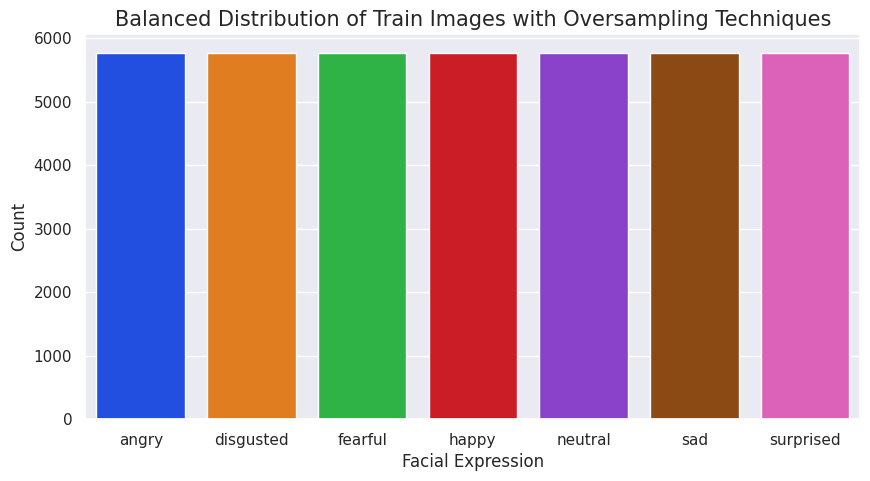

In [28]:
df_train_gen = pds.DataFrame(list(class_counts.items()), columns=['Emotion', 'Count'])
df_train_gen.index.name = 'Emotion'


# plot a barplot with vertical orientation
sns.set()
plt.figure(figsize=(10, 5))
sns.barplot(x='Emotion', y='Count', data=df_train_gen, orient='v', palette='bright')
plt.xlabel("Facial Expression", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Balanced Distribution of Train Images with Oversampling Techniques", fontsize=15)
plt.show()

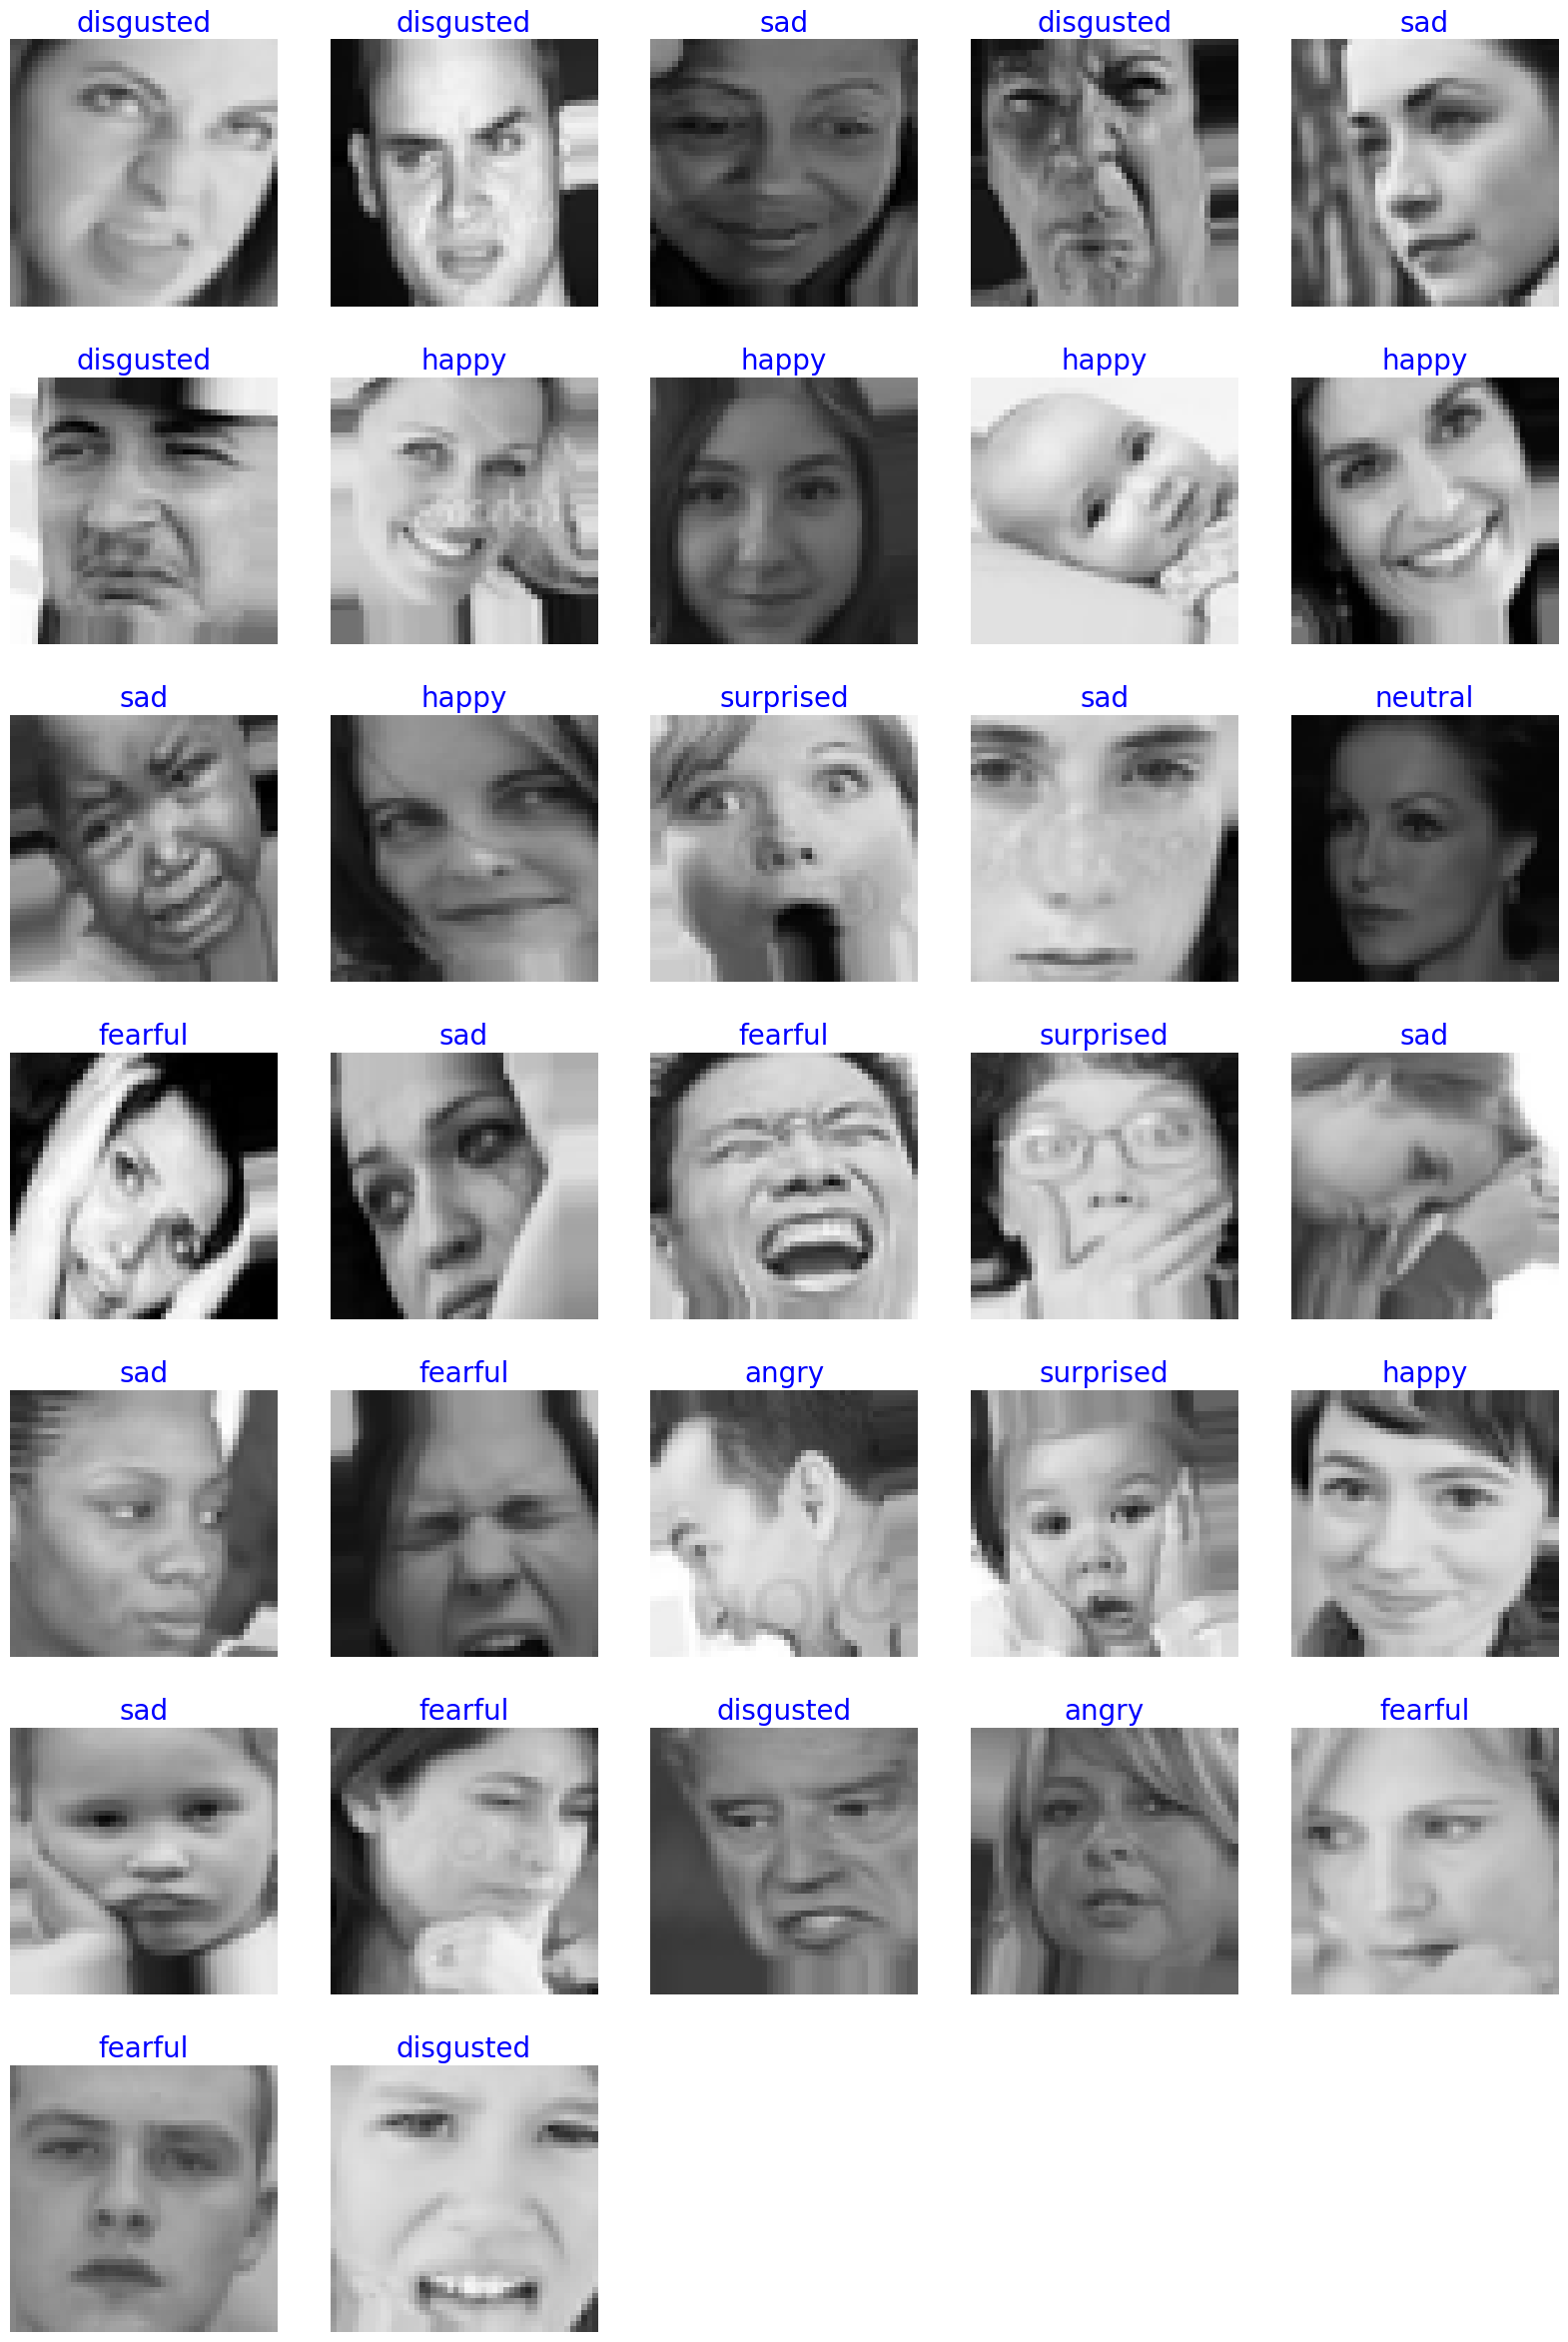

In [29]:
# Get the sample images, labels, and their filenames 
# To get the correct filename, turn off the shuffle
def plotImageWithNames(gen):
    images, labels = next(gen)
    filenames = gen.filenames
    classes = list(gen.class_indices.keys())
    
    plt.figure(figsize=(20, 30))
    length=len(labels)
    if length<32:  
        r=length
    else:
        r=32
    for i in range(r):        
        plt.subplot(7, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=npy.argmax(labels[i])
        class_name=classes[index]
        filename=gen.filenames[i]
        plt.title(
                    label=f"{class_name}", # \n{filename} ", 
                    color='blue', 
                    fontsize=20
                    )
        plt.axis('off')
    plt.show()

plotImageWithNames(train_generator)

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "model-development"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Model Development
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#model-development">¶</a>
    </h1>
</div>

In [30]:
from tensorflow import keras
from sklearn import set_config
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras import layers, optimizers, metrics, regularizers, models
from tensorflow.keras.optimizers import Adam, Adamax
# from tensorflow.keras.metrics import categorical_crossentropy, sparse_categorical_crossentropy


In [31]:
# define the image shape for the input layer
input_shape=(target_size[0], target_size[1], 3)
batch_size = batch_size
epochs=60
ask_epoch=0


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "model-building-and-compiling"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Model Building and Compiling
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#model-building-and-compiling">¶</a>
    </h1>
</div>

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Model
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(
                                                            include_top=False, 
                                                            weights="imagenet",
                                                            input_shape=input_shape, 
                                                            pooling='max'
                                                            ) 

# Let's make our base_model trainable to get better results
base_model.trainable=True
x=base_model.output

x=BatchNormalization(
                    axis=-1, 
                    momentum=0.99, 
                    epsilon=0.001,
                    name='batch_norm_x' 
                    )(x)
x = Dense(
          256, 
          kernel_regularizer = regularizers.l2(l = 0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu',
          name='dense_x'
          )(x)

x=Dropout(
          rate=.4, 
          seed=123,
          name='dropout_x'
          )(x) 
      
output=Dense(
            class_count, 
            activation='softmax',
            name='dense_output'
            )(x)
cnn_model=Model(inputs=base_model.input, outputs=output, name=model_name)
learning_rate=.001 # start with this learning rate
cnn_model.compile(
                  Adamax(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy']
                  )

# View the model summary
cnn_model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "EfficientNetB3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 48, 48, 3)    0           ['normalization[0][0]']          
                    

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.75985 to fit



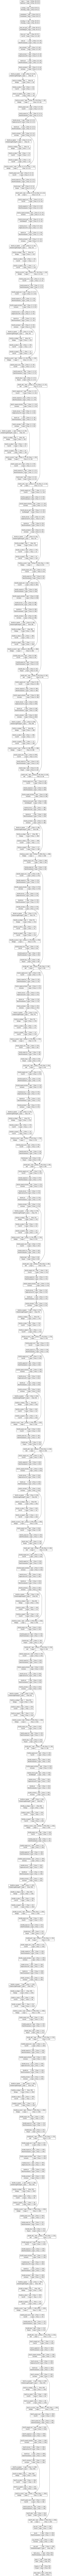

In [33]:
# Plot the Model Diagram
set_config(display="diagram")
from keras.utils.vis_utils import plot_model
plot_model(cnn_model, to_file=model_arch(model_name), show_shapes=True)

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "create-a-custom-keras-callback-to-continue-or-halt-training"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;"> Create a Custom Keras Callback to Continue or Halt Training
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn##create-a-custom-keras-callback-to-continue-or-halt-training">¶</a>
    </h1>
</div>

In [34]:
# Code by https://www.kaggle.com/code/gpiosenka/callback-to-continue-or-halt-training-f1-90
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.subask_epoch = int(ask_epoch/2)
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou earlier specified a maximum epochs of ', self.epochs, '\n, its seems that you want to train for a total of', self.ask_epoch,'\n\n Please confirm your action, please enter "Y", or "N" to end training at ', self.epochs)
                        ans=input()
                        
                        if ans == 'Y' or ans =='y':
                            self.epochs = self.ask_epoch
                        else:
                             print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        
ask=ASK(cnn_model, epochs,  ask_epoch)

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "checkpoint-callback"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Checkpoint Callback
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn##checkpoint-callback">¶</a>
    </h1>
</div>

<div>
    <h2 style = "padding: 3px; 
                 color: #256d7c;
                 font-size: 30px;
                 font-family: Cambria;
                 font-weight: bold;">Checkpoint 1: Save Weight Only
    </h2>
</div>

Creates a single collection of TensorFlow checkpoint files that are updated at the end of each epoch.

As long as two models share the same architecture, the weights between them can be shared. So, when restoring a model from weights-only, create a model with the same architecture as the original model and then set its weights.

In [35]:
# starting the Checkpoint for the model
# checkpoint_dir = os.path.dirname(checkpoint_path)

check_point = tf.keras.callbacks.ModelCheckpoint(
                                          filepath=checkpoint_path(model_name),
                                          save_weights_only=True,
                                          save_best_only=True, 
                                          monitor="val_accuracy",
                                          verbose = 1,
                                        )

reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor="val_accuracy", 
                                            # factor=0.5, 
                                            patience=2,
                                            verbose=1
                                            )

early_stop = tf.keras.callbacks.EarlyStopping(
                                       monitor="val_accuracy", 
                                       min_delta=0.0005,
                                       patience=11, 
                                       verbose=1,
                                       restore_best_weights=True
                                       )

callbacks = [
            check_point,
            reduce_learning, 
            early_stop, 
            # ask
          ]

<div>
    <h2 style = "padding: 3px; 
                 color: #256d7c;
                 font-size: 30px;
                 font-family: Cambria;
                 font-weight: bold;">Checkpoint 2: Save Entire Model
    </h2>
</div>


In [36]:
# starting the Checkpoint for the model
e_checkpoint_path = "models/fedav_best_model.h5"
checkpoint_dir = os.path.dirname(e_checkpoint_path)

e_check_point = tf.keras.callbacks.ModelCheckpoint(
                                          filepath=e_checkpoint_path,
                                          save_weights_only=True,
                                          save_best_only=True, 
                                          monitor="val_accuracy",
                                          verbose = 1,
                                        )

e_reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor="val_accuracy", 
                                            # factor=0.5, 
                                            patience=2,
                                            verbose=1
                                            )

e_early_stop = tf.keras.callbacks.EarlyStopping(
                                       monitor="val_accuracy", 
                                       min_delta=0.0005,
                                       patience=11, 
                                       verbose=1,
                                       restore_best_weights=True
                                       )

e_callbacks = [
#             e_check_point,
            e_reduce_learning, 
            e_early_stop, 
            # ask
          ]

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "model-training"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Model Training
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn##model-training">¶</a>
    </h1>
</div>

In [37]:
model_history=cnn_model.fit(
                  train_generator,  
                  steps_per_epoch=train_generator.n//train_generator.batch_size,
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks,  
                  validation_data=validation_generator,
                #   validation_steps=None, 
                  validation_steps= validation_generator.n//validation_generator.batch_size,
                  )


Epoch 1/60
1262/1262 [==============================] - ETA: 0s - loss: 4.8159 - accuracy: 0.3253
Epoch 1: val_accuracy improved from -inf to 0.45169, saving model to /content/models/fedav_best_model-EfficientNetB3.ckpt
1262/1262 [==============================] - 226s 119ms/step - loss: 4.8159 - accuracy: 0.3253 - val_loss: 2.2393 - val_accuracy: 0.4517 - lr: 0.0010
Epoch 2/60
1262/1262 [==============================] - ETA: 0s - loss: 1.7797 - accuracy: 0.4829
Epoch 2: val_accuracy improved from 0.45169 to 0.53869, saving model to /content/models/fedav_best_model-EfficientNetB3.ckpt
1262/1262 [==============================] - 150s 119ms/step - loss: 1.7797 - accuracy: 0.4829 - val_loss: 1.4554 - val_accuracy: 0.5387 - lr: 0.0010
Epoch 3/60
1262/1262 [==============================] - ETA: 0s - loss: 1.4049 - accuracy: 0.5501
Epoch 3: val_accuracy improved from 0.53869 to 0.60347, saving model to /content/models/fedav_best_model-EfficientNetB3.ckpt
1262/1262 [=======================

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "acuracy-and-loss-function-graph"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Accuracy and Loss Function Graph
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn#acuracy-and-loss-function-graph">¶</a>
    </h1>
</div>

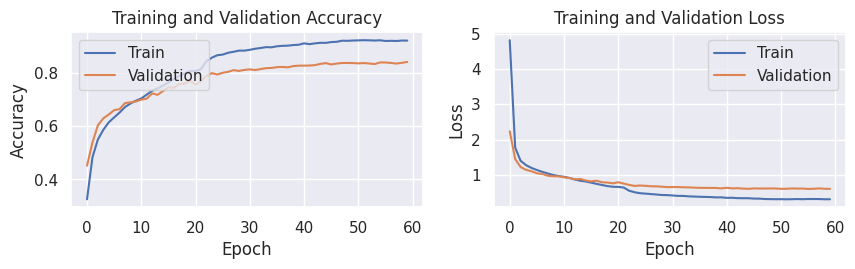

In [38]:
from pylab import rcParams
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
start_epoch = 0
Epoch_count=len(acc)+ start_epoch
Epochs=[]
for i in range (start_epoch ,Epoch_count):
    Epochs.append(i+1)   
index_loss=npy.argmin(val_loss)   #   this is the epoch with the lowest validation loss
val_lowest=val_loss[index_loss]
index_acc=npy.argmax(val_acc)


# summarize history for accuracy using reLU
sns.set()
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



# summarize history for loss using reLU
plt.subplot(2, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


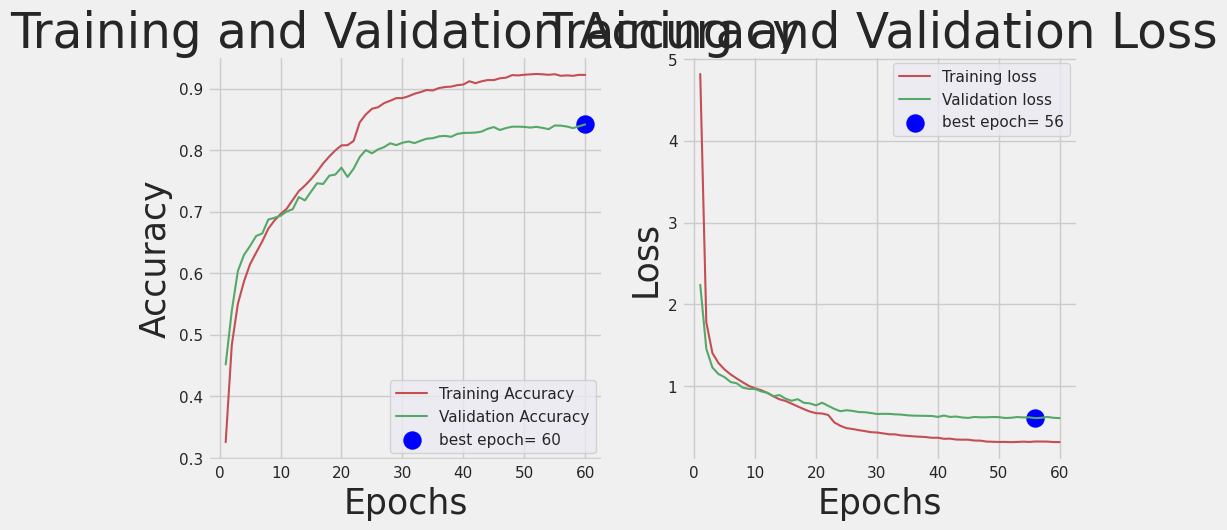

In [39]:
# Code by https://www.kaggle.com/code/gpiosenka/callback-to-continue-or-halt-training-f1-90
def trainValPlot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=npy.argmin(vloss)   #   this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=npy.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    sns.set()
    axes[0].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[0].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[0].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[0].set_title('Training and Validation Accuracy', fontsize=35)
    axes[0].set_xlabel('Epochs', fontsize=25)
    axes[0].set_ylabel('Accuracy', fontsize=25)
    axes[0].legend()
    axes[1].plot(Epochs,tloss, 'r', label='Training loss')
    axes[1].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[1].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[1].set_title('Training and Validation Loss', fontsize=35)
    axes[1].set_xlabel('Epochs', fontsize=25)
    axes[1].set_ylabel('Loss', fontsize=25)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
trainValPlot(model_history,0)


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "model-evaluation"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Model Evaluation
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn##model-evaluation">¶</a>
    </h1>
</div>

In [40]:
# Rebuild a fresh, untrained model and evaluate it on the test set. 
# An untrained model will perform at chance levels (~10% accuracy)
# Create a basic model instance
model = cnn_model

# Evaluate the model
loss, acc = model.evaluate(train_generator, verbose=2)

1263/1263 - 59s - loss: 0.1994 - accuracy: 0.9635 - 59s/epoch - 47ms/step


In [41]:
# Rebuild a fresh, untrained model and evaluate it on the test set. 
# An untrained model will perform at chance levels (~10% accuracy)
# Create a basic model instance
model = cnn_model

# Evaluate the model
loss, acc = model.evaluate(validation_generator, verbose=2)

316/316 - 16s - loss: 0.6186 - accuracy: 0.8378 - 16s/epoch - 50ms/step


In [42]:
# Loads the weights
cnn_model.load_weights(checkpoint_path(model_name=model_name))

# Re-evaluate the model
loss, acc = cnn_model.evaluate(validation_generator, verbose=2)
print("Restored model, validation accuracy: {:5.2f}%".format(100 * acc))

316/316 - 15s - loss: 0.6156 - accuracy: 0.8364 - 15s/epoch - 46ms/step
Restored model, validation accuracy: 83.64%


In [43]:
# Loads the weights
cnn_model.load_weights(checkpoint_path(model_name))

# Re-evaluate the model
loss, acc = cnn_model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy on New Test data: {:5.2f}%".format(100 * acc))

1/1 - 0s - loss: 1.3519 - accuracy: 0.6562 - 56ms/epoch - 56ms/step
Restored model, accuracy on New Test data: 65.62%


<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #256d7c;">
    <h1 id = "prediction-on-test-images"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 35px;
                 font-family: Cambria;
                 font-weight: bold;">Prediction on Test Images
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/charlesanjah/keratoconus-eye-disease-detection-using-cnn##prediction-on-test-images">¶</a>
    </h1>
</div>

In [44]:
# 
def ModelPredictionOnTestDataset(test_generator=test_generator):
#     test_steps= test_generator.n//test_generator.batch_size
    y_pred= []
    y_label=test_generator.labels
    classes=list(train_generator.class_indices.keys())
    class_count=len(classes)
    wrong_predictions=0
    
    # predict on the test set
    preds=cnn_model.predict(test_generator, test_steps, verbose=1) 
    
    total_predictions=len(preds)
    print(f'total prediction: {total_predictions}')
    for i, p in enumerate(preds):
            pred_index=npy.argmax(p)  
            # labels are integer values       
            true_index=test_generator.labels[i]  
            if pred_index != true_index:       
                # a misclassification has occurred                                     
                wrong_predictions=wrong_predictions + 1
            y_pred.append(pred_index)
    acc=( 1-wrong_predictions/total_predictions) * 100
    print(f'\n{wrong_predictions} out of {total_predictions} tested images could not be detected properly.\nAccuracy of {acc:6.2f}\n')
    ypred=npy.array(y_pred)
    ytrue=npy.array(y_label)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(8, 4))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(npy.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(npy.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix on Validation Data", fontsize=40)
        plt.show()
    clr = classification_report(y_label, y_pred, target_names=classes, digits= 5) # create classification report
    print("Classification Report on Validation Data:\n-------------------------------------\n", clr)

#     # Plot the confusion matrix
#         ConfusionMatrix(
#                         label_test=ytrue, 
#                         label_prep=ypred, 
#                         class_count=class_count, 
#                         class_keys=class_keys, 
#                         heada=' for Entire Test Set'
#                         )
        
    return wrong_predictions, total_predictions



316/316 [==============================] - 18s 51ms/step
total prediction: 10101

1625 out of 10101 tested images could not be detected properly.
Accuracy of  83.91



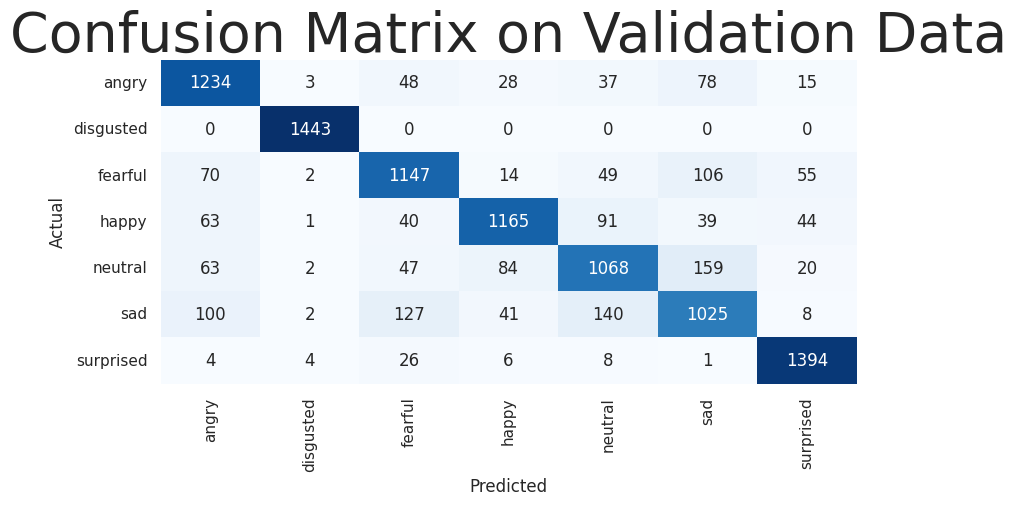

Classification Report on Validation Data:
-------------------------------------
               precision    recall  f1-score   support

       angry    0.80443   0.85516   0.82902      1443
   disgusted    0.99039   1.00000   0.99517      1443
     fearful    0.79930   0.79487   0.79708      1443
       happy    0.87070   0.80735   0.83783      1443
     neutral    0.76669   0.74012   0.75317      1443
         sad    0.72798   0.71033   0.71905      1443
   surprised    0.90755   0.96604   0.93588      1443

    accuracy                        0.83912     10101
   macro avg    0.83815   0.83912   0.83817     10101
weighted avg    0.83815   0.83912   0.83817     10101



In [45]:
# Validation
wrong_predictions, total_predictions = ModelPredictionOnTestDataset(validation_generator)

225/225 [==============================] - 6s 26ms/step
total prediction: 7178

2480 out of 7178 tested images could not be detected properly.
Accuracy of  65.45



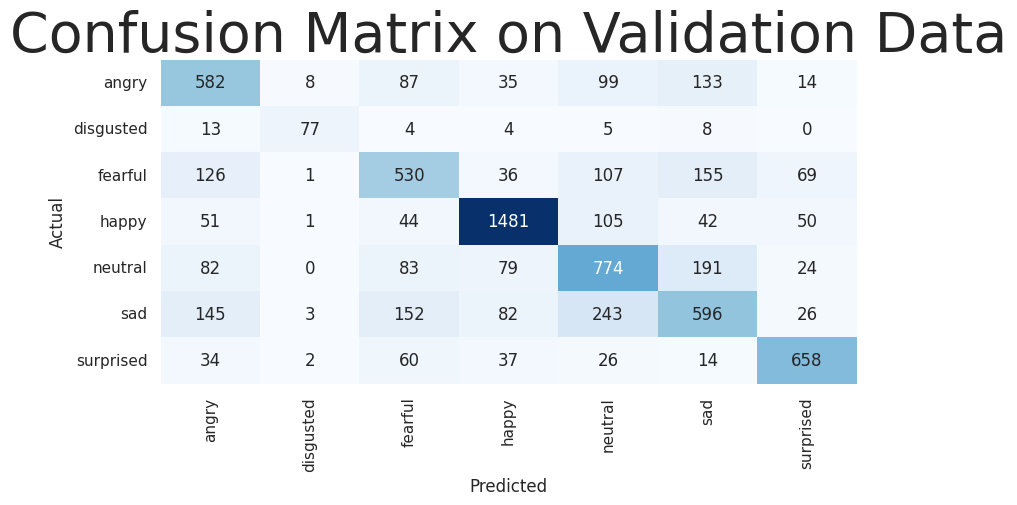

Classification Report on Validation Data:
-------------------------------------
               precision    recall  f1-score   support

       angry    0.56341   0.60752   0.58463       958
   disgusted    0.83696   0.69369   0.75862       111
     fearful    0.55208   0.51758   0.53427      1024
       happy    0.84436   0.83484   0.83957      1774
     neutral    0.56954   0.62774   0.59722      1233
         sad    0.52327   0.47795   0.49958      1247
   surprised    0.78240   0.79182   0.78708       831

    accuracy                        0.65450      7178
   macro avg    0.66743   0.65016   0.65728      7178
weighted avg    0.65489   0.65450   0.65397      7178



(2480, 7178)

In [46]:
# Test Set 
ModelPredictionOnTestDataset()

<div>
    <h2 style = "padding: 3px; 
                 color: #256d7c;
                 font-size: 30px;
                 font-family: Cambria;
                 font-weight: bold;">Print Predicted Images: Unshuffled Test Set
    </h2>
</div>

1/1 [==============================] - 3s 3s/step
correct prediction: 0.625 



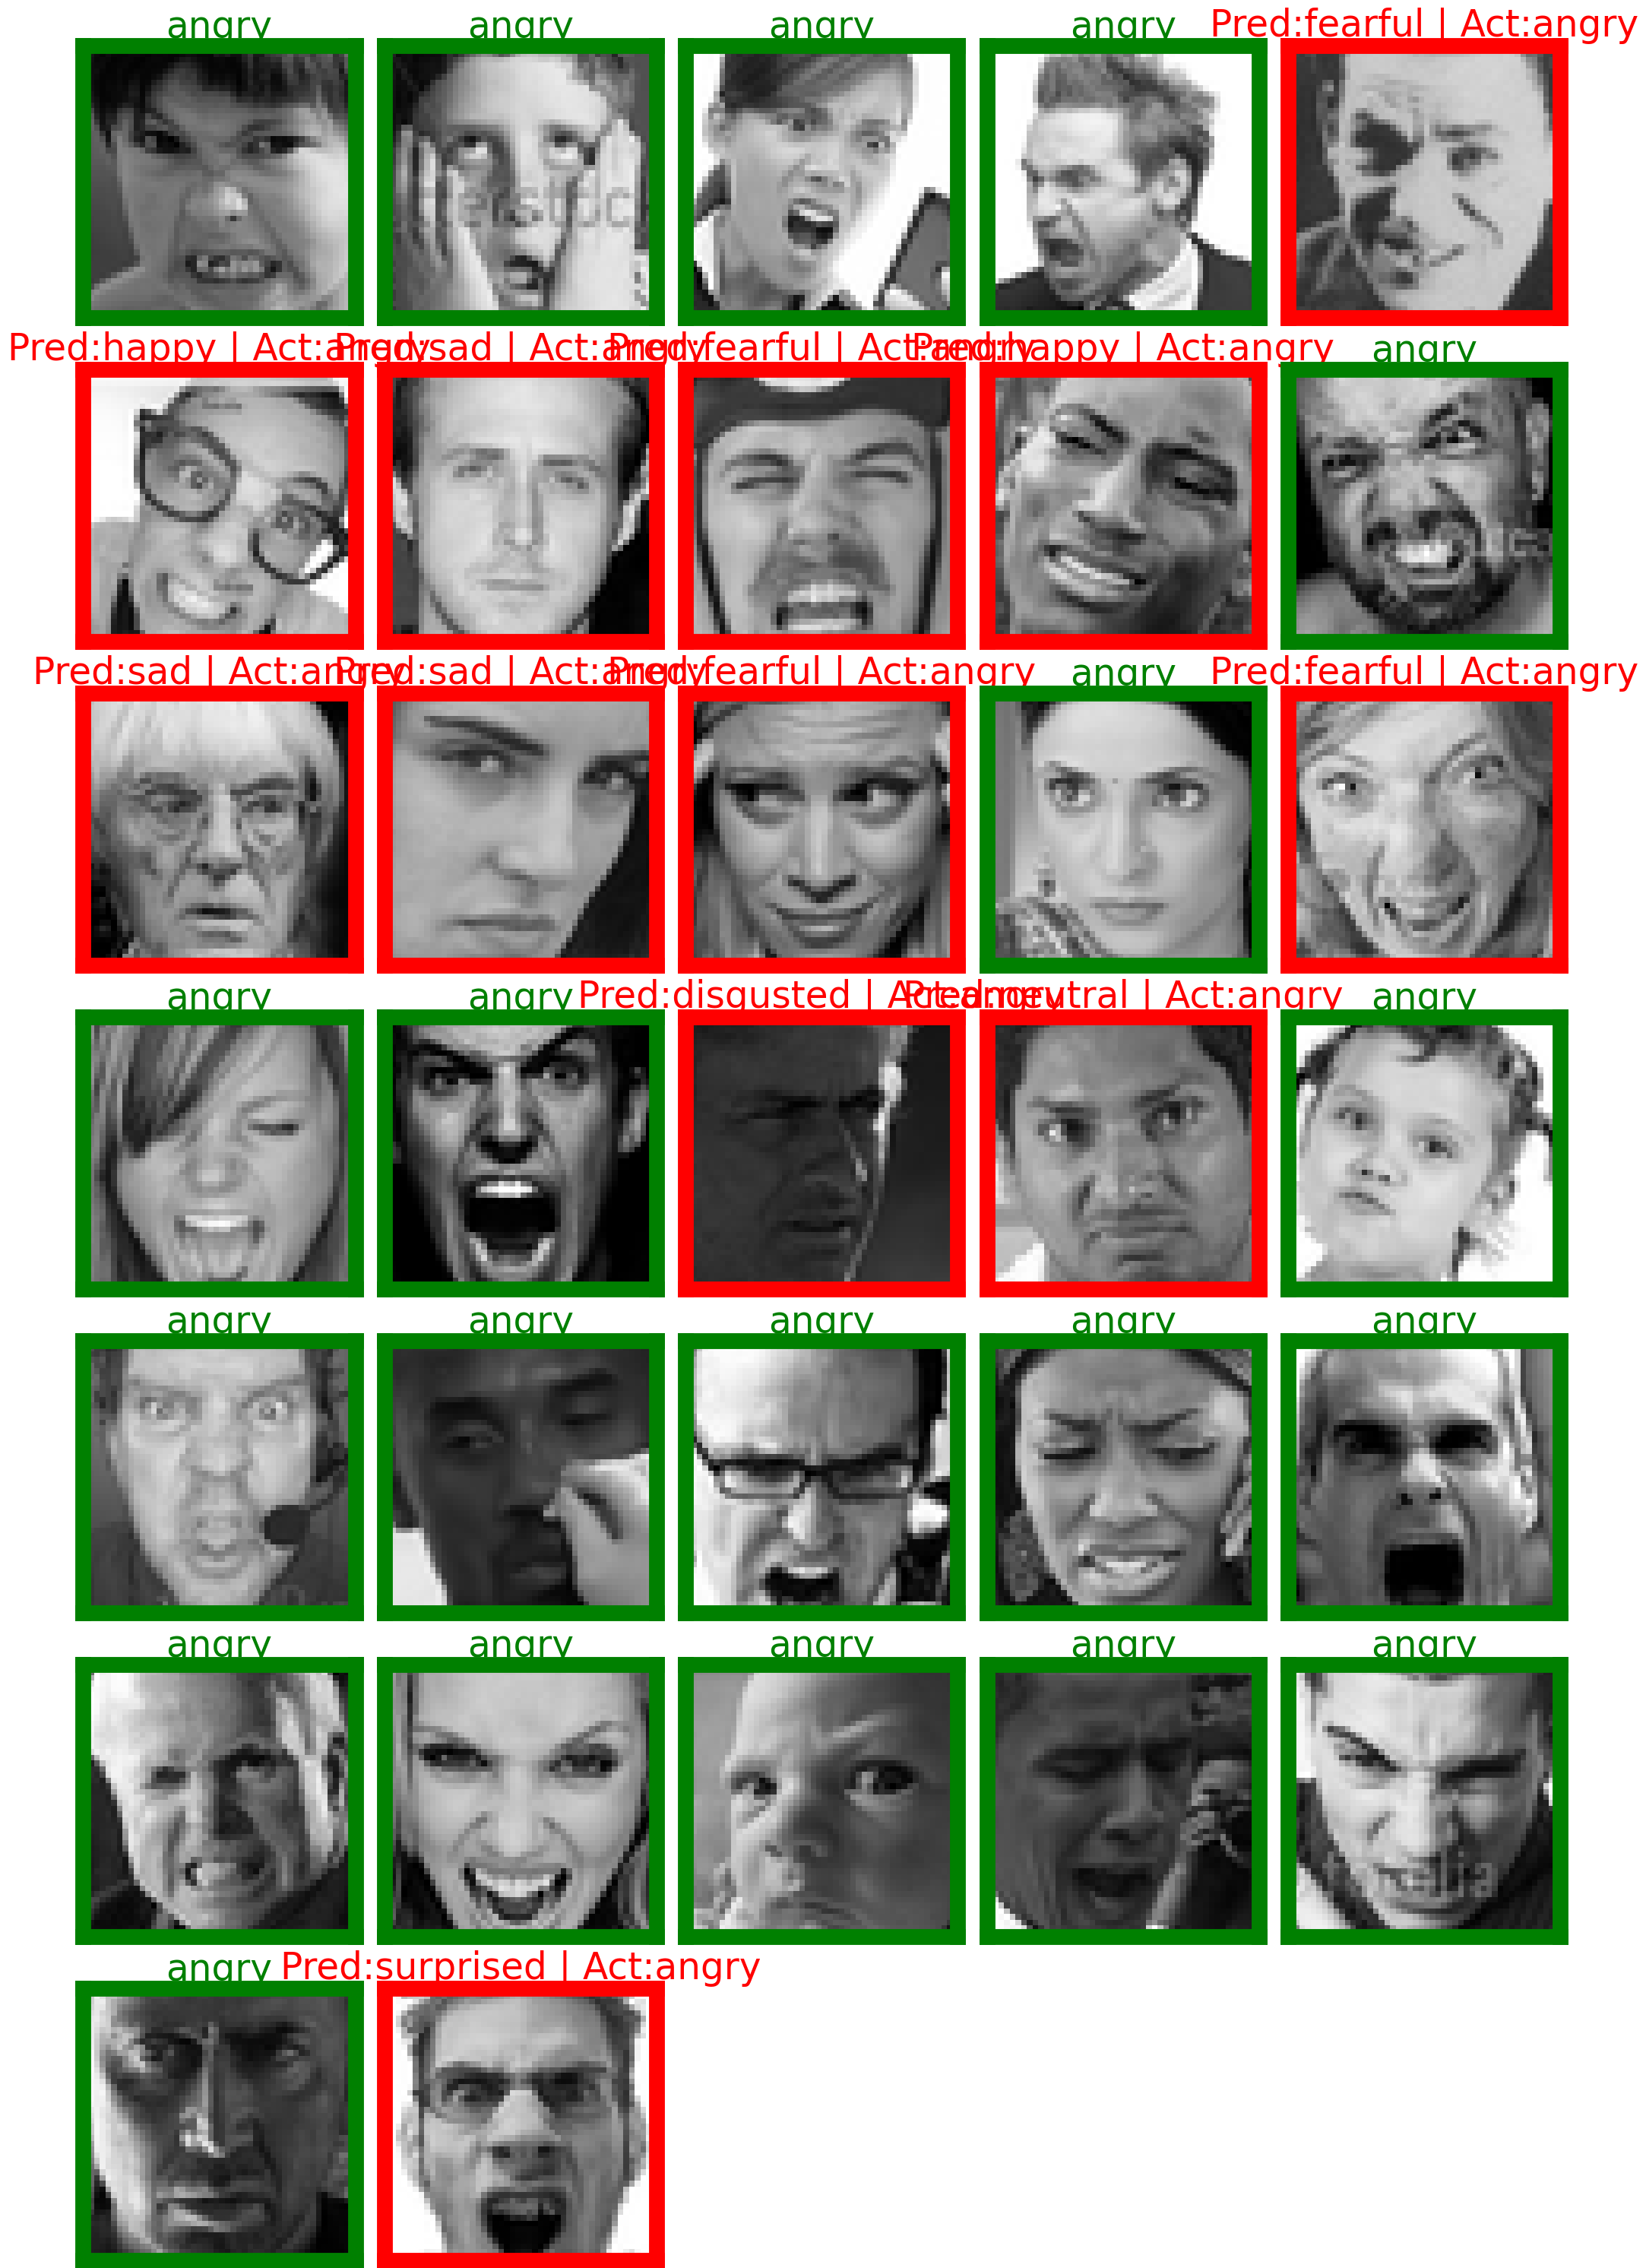

In [47]:
# 
test_images, test_labels = next(test_generator)
preds = cnn_model.predict(test_images)
# One hot conversion
label_prep = npy.argmax(preds, axis = 1)
label_test = npy.argmax(test_labels, axis = 1)
# Reshape
label_prep = label_prep.reshape((-1, 1))
label_test = npy.reshape(label_test, (len(label_test), 1))

print('correct prediction:', npy.sum((label_test == label_prep)*1)/test_batch_size,'\n')


def compare(label_prep, gen=train_generator):
    class_dictionary = gen.class_indices
    for key, value in class_dictionary.items():
        if value == label_prep:
             return key

def dif(label_test, label_prep, gen=train_generator):    
    class_dictionary = gen.class_indices
    test = ''
    id = ''
    for key, value in class_dictionary.items():
        if value == label_test:
            test = key
        if value == label_prep:
            id = key
    return test, id

#Code by Hitesh Kumar https://www.kaggle.com/hitzz97/emotion-detection

fig = plt.figure(figsize=((20, 30)))

# k = 0
for j in range(len(label_prep)):
    ax = plt.subplot(7, 5, j+1)
    px = test_images[j]/255
#     k += 1
    ax.imshow(px)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if label_test[j] == label_prep[j]:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(15)
            ax.spines[axis].set_color('green')
        ax.set_title(
                    compare(label_prep[j]),
                    color='green', 
                    fontsize=35
                     )

    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(15)
            ax.spines[axis].set_color('red')
        ax.set_title(
                    'Pred:'+dif(label_test[j], label_prep[j])[1]+" | Act:"+ dif(label_test[j], label_prep[j])[0],
                    color='red', 
                    fontsize=35
                    )
    plt.tight_layout()

<div>
    <h2 style = "padding: 3px; 
                 color: #256d7c;
                 font-size: 30px;
                 font-family: Cambria;
                 font-weight: bold;">Print Predicted Images: Shuffled Test Set
    </h2>
</div>

1/1 [==============================] - 0s 40ms/step
correct prediction: 0.65625


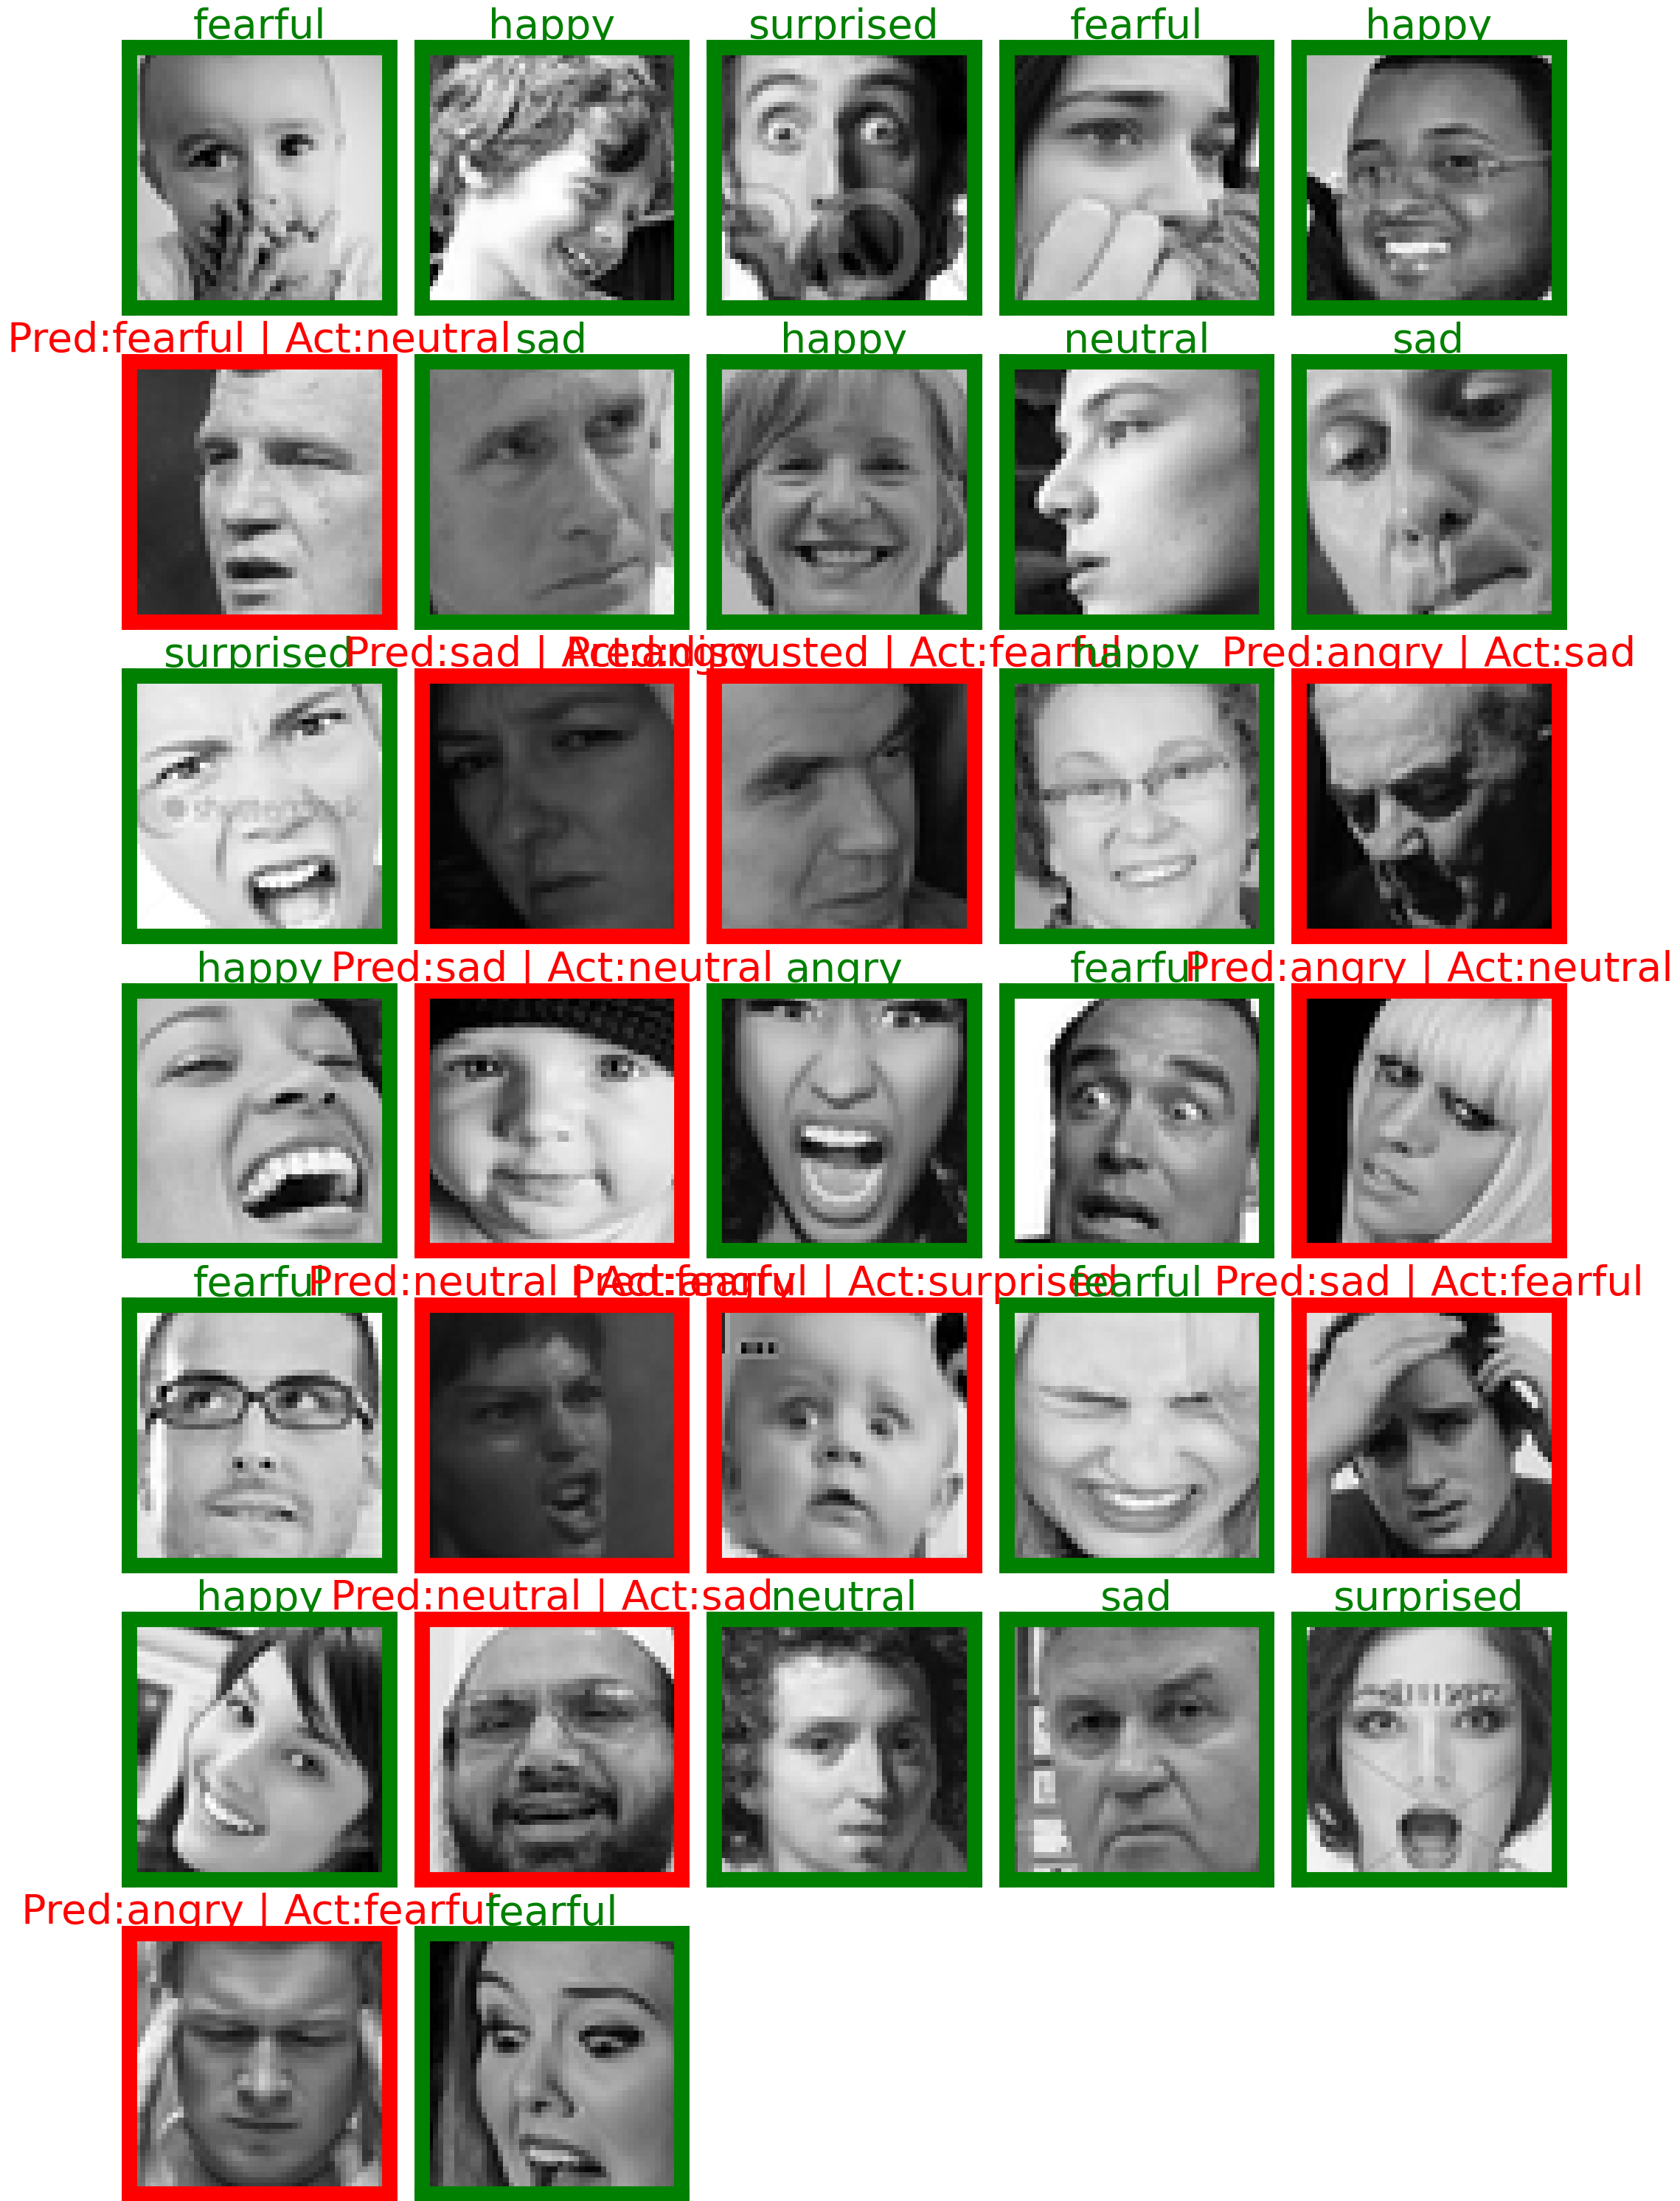

In [48]:
#Code by Hitesh Kumar https://www.kaggle.com/hitzz97/emotion-detection


test_images, test_labels = next(test_generator_shuffled)
preds = cnn_model.predict(test_images)
# print(preds)
idx = npy.argmax(preds, axis = 1)
# test_labels = test_labels.astype(int)
test_labels = npy.argmax(test_labels, axis = 1)
idx = idx.reshape((-1, 1))
test_labels = npy.reshape(test_labels, (len(test_labels), 1))
# print()
print('correct prediction:', npy.sum((test_labels == idx)*1)/test_batch_size)


def compare(idx, train_generator):
    class_dictionary = train_generator.class_indices
    for key, value in class_dictionary.items():
        if value == idx:
             return key

def dif(test_labels, idx, train_generator):    
    class_dictionary = train_generator.class_indices
    test = ''
    id = ''
    for key, value in class_dictionary.items():
        if value == test_labels:
            test = key
        if value == idx:
            id = key
    return test, id


#Code by Hitesh Kumar https://www.kaggle.com/hitzz97/emotion-detection

fig = plt.figure(figsize=((20, 30)))

# k = 0
for j in range(len(idx)):
    ax = plt.subplot(7, 5, j+1)
    px = test_images[j]/255
#     k += 1
    ax.imshow(px)
    ax.set_xticks([])
    ax.set_yticks([])
    
#     print(idx[j])
#     print(test_labels[j])
    if test_labels[j] == idx[j]:
#     if  class_dictionary[test_labels[j]] == class_dictionary[idx[j]]:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(15)
            ax.spines[axis].set_color('green')
        ax.set_title(
                    compare(idx[j], train_generator),
                    color='green', 
                    fontsize=40
                     )

    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(15)
            ax.spines[axis].set_color('red')
        ax.set_title(
                    'Pred:'+dif(test_labels[j], idx[j], train_generator)[1]+" | Act:"+ dif(test_labels[j], idx[j], train_generator)[0],
                    color='red', 
                    fontsize=40
                    )
    plt.tight_layout()

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              ">
    <blockquote id = "prediction-on-shuffled-test-images"
        style = "padding: 18px; 
                 color: #f8e7b5;
                 font-size: 25px;
                 font-family: Cambria;
                 font-weight: bold;">References
    <ul style ="font-family: Cambria;
                 color: #256d7c;
                 font-size: 15px;
                 font-family: Cambria;
                 font-weight: regular;">
        <li><a href="https://www.kaggle.com/charlesanjah/optimizing-facial-emotion-detection-efficientnet/edit">Optimising Facial Emotion Detection EfficientNet</a></li>
        <li><a href="https://www.kaggle.com/code/gpiosenka/callback-to-continue-or-halt-training-f1-90">Callback to continue or halt training</a></li>
        <li><a href="https://www.kaggle.com/code/charlesanjah/mobilenet-based-emotion-recognition/edit">Markdown Graphics</a></li>
    </ul>
   </blockquote>

 </div>

# **Saving Model**

In [49]:

# Save the entire model in the SavedModel format
tf.saved_model.save(model, '/content/drive/MyDrive/models/cnn_efficientnetb3_model')
# # load the entire model in the SavedModel format
# loaded_model = tf.saved_model.load('efficientnetb3_model')

## Another Way of Saving Model

In [53]:
# Save the weights of the model
model.save_weights('/content/drive/MyDrive/models/cnn_efficientnetb3_model_weights.h5')

# # load the weights of the model
# # Create an instance of the EfficientNet-B3 model
# base_model = EfficientNetB3(include_top=False, weights=None)

# # Add your custom layers on top of the base model
# model = tf.keras.Sequential([
#     base_model,
#     # Add your custom layers here
# ])

# # Load the saved weights into the model
# model.load_weights("efficientnet_b3_weights.h5")


##  Making a single prediction

In [72]:
import numpy as np
import keras.utils as image

test_image = image.load_img('/content/sinlge/15.jpg', target_size=(48, 48))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

result = cnn_model.predict(test_image)
print(class_indices)

predicted_class_index = np.argmax(result[0])
for key, val in class_indices.items():
        if val == predicted_class_index:
            predicted_class = key

print(predicted_class," ",predicted_class_index)

1/1 [==============================] - 0s 57ms/step
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
fearful   2
